In [1]:
import re
import time 
import pandas as pd
import numpy as np
import os
import joblib 
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.utils import shuffle # to shuffle the data 


from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### There are 25 variables:

ID: ID of each client
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
SEX: Gender (1=male, 2=female)
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
MARRIAGE: Marital status (1=married, 2=single, 3=others)
AGE: Age in years
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
PAY_2: Repayment status in August, 2005 (scale same as above)
PAY_3: Repayment status in July, 2005 (scale same as above)
PAY_4: Repayment status in June, 2005 (scale same as above)
PAY_5: Repayment status in May, 2005 (scale same as above)
PAY_6: Repayment status in April, 2005 (scale same as above)
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
default.payment.next.month: Default payment (1=yes, 0=no)

In [2]:
data = pd.read_csv("UCI_Credit_Card.csv")

In [3]:
data.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [4]:
#changing the column names
data = data.rename(columns={'default.payment.next.month': 'default_pay', 'PAY_0': 'PAY_1'})

In [35]:
lis = [ 'LIMIT_BAL','AGE','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [6]:
data.head()
# default_pay (1=yes, 0=No)
# gender (1=male, 2=female)
# MARRIAGE (1=married, 2=single, 3=others)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
data.shape

(30000, 25)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           30000 non-null  int64  
 1   LIMIT_BAL    30000 non-null  float64
 2   SEX          30000 non-null  int64  
 3   EDUCATION    30000 non-null  int64  
 4   MARRIAGE     30000 non-null  int64  
 5   AGE          30000 non-null  int64  
 6   PAY_1        30000 non-null  int64  
 7   PAY_2        30000 non-null  int64  
 8   PAY_3        30000 non-null  int64  
 9   PAY_4        30000 non-null  int64  
 10  PAY_5        30000 non-null  int64  
 11  PAY_6        30000 non-null  int64  
 12  BILL_AMT1    30000 non-null  float64
 13  BILL_AMT2    30000 non-null  float64
 14  BILL_AMT3    30000 non-null  float64
 15  BILL_AMT4    30000 non-null  float64
 16  BILL_AMT5    30000 non-null  float64
 17  BILL_AMT6    30000 non-null  float64
 18  PAY_AMT1     30000 non-null  float64
 19  PAY_

In [9]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [10]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

EDUCATION has categories 5, 6 and 0 that are unlabelled.
MARRIAGE has a label 0 that is undocumented

In [11]:
for i in (0,5,6):
    data['EDUCATION'].replace(i, 4,inplace=True)

In [12]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [13]:
# changing '0' to '3' for marriage (1=married, 2=single, 3=others)
data['MARRIAGE'].replace(0, 3, inplace=True)

for payment we are now using (0=pay duly, 1 = delay for one month, 2 = delay for two months etc.) and repalcing the negative integers with 0.

In [14]:
data.PAY_1.value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

In [15]:
for i in list(data.columns[6:12]):
    data[i].replace(-1, 0,inplace=True)
    data[i].replace(-2, 0,inplace=True)

### replace all negative values with nan in dataset 

In [16]:
for i in list(data.columns[12:18]):
    data.loc[(data[i] < 0), i]=np.nan

In [17]:
#number of nan values in dataset
data.iloc[:,12:18 ].isnull().sum()

BILL_AMT1    590
BILL_AMT2    669
BILL_AMT3    655
BILL_AMT4    675
BILL_AMT5    655
BILL_AMT6    688
dtype: int64

In [21]:
data.iloc[:,24].value_counts()

0    23364
1     6636
Name: default_pay, dtype: int64

### Replacing the nan values using imputation method
There are clients that paid more then they were asked to, had even a negative bill in Sept., and still have a month of delay, and even defaulted the next month, so i am going to convert all the negative values into nan's and will replace them with mean.

In [22]:
data['BILL_AMT1'].loc[5]

64400.0

In [47]:
data['BILL_AMT1'].loc[5] = np.nan

now we will fill the 5th location with mean/median and use the method which gives the closest result.

In [48]:
data['BILL_AMT1'].mean()

52273.68686456527

In [49]:
data['BILL_AMT1'].median()

23790.0

As mean is closer to actual result so using the mean to fill the nan values.

In [50]:
for i in list(data.columns[12:18]):
    data[i] = data[i].fillna(data[i].mean())

In [51]:
data.iloc[:,12:18 ].isna().sum()

BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64

### Replacing the missing values with KNN imputation

##### This is the second method used for comapring the null value replacement

In [23]:
data2 = data

In [24]:
data2.iloc[:,12:18].isna().sum()

BILL_AMT1    590
BILL_AMT2    669
BILL_AMT3    655
BILL_AMT4    675
BILL_AMT5    655
BILL_AMT6    688
dtype: int64

Replacing the missing values with KNN imputation

In [25]:
from sklearn.impute import KNNImputer

In [28]:
imputer = KNNImputer(n_neighbors=2)
for i in list(data2.columns[12:18]):
    data2[i]= imputer.fit_transform(data2[[i]]) 

In [30]:
data2.iloc[:,12:18].isna().sum()

BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64

### Outlier Analysis

In [31]:
lis

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_pay']

In [32]:
# for i in lis:
#     data2.loc[:,i] = data2.loc[:,i].astype('object')

CPU times: user 34.5 ms, sys: 3.69 ms, total: 38.2 ms
Wall time: 36.2 ms


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc42ad0cd50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc42ad1a610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc42ad0c890>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc42ad1aed0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc42ad1f350>],
 'means': []}

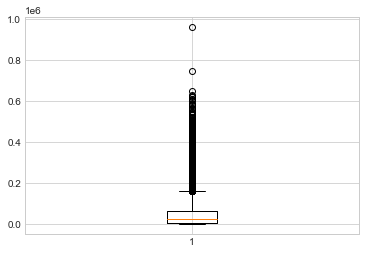

In [33]:
%%time
%matplotlib inline 
plt.boxplot(data2['BILL_AMT1'])

CPU times: user 33.6 ms, sys: 3.38 ms, total: 37 ms
Wall time: 36 ms


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc42a84c750>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc42a84cfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc42a84c390>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc42a82c8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc42acfce10>],
 'means': []}

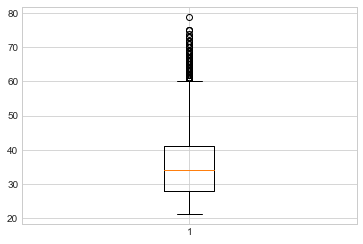

In [34]:
%%time
%matplotlib inline 
plt.boxplot(data2['AGE'])

### Replacing the outliers with nan

In [36]:
values = []
for i in lis:
    Q1 = data2[i].quantile(0.25)
    Q3 = data2[i].quantile(0.75)
    IQR = Q3 - Q1
    min1 = Q1 - (IQR*1.5)
    max1 = Q3 + (IQR*1.5)
    values.append((min1, max1))
    print(i) 
    print(((data2[i] < (Q1 - 1.5 * IQR)) | (data2[i] > (Q3 + 1.5 * IQR))).sum())

LIMIT_BAL
167
AGE
272
BILL_AMT1
2430
BILL_AMT2
2426
BILL_AMT3
2504
BILL_AMT4
2670
BILL_AMT5
2766
BILL_AMT6
2727
PAY_AMT1
2745
PAY_AMT2
2714
PAY_AMT3
2598
PAY_AMT4
2994
PAY_AMT5
2945
PAY_AMT6
2958


In [37]:
outlier_list = pd.DataFrame(values, columns = ['min1' , 'max1']) 

In [38]:
outlier_list.head(3)

,min1,max1
0,-235000.00,525000.00
1,8.50,60.50
2,-89447.75,161014.25


In [39]:
for i in lis:
    Q1 = data2[i].quantile(0.25)
    Q3 = data2[i].quantile(0.75)
    IQR = Q3 - Q1
    min1 = Q1 - (IQR*1.5)
    max1 = Q3 + (IQR*1.5)
    data2.loc[data2[i]<min1, i] =np.nan
    data2.loc[data2[i]>max1, i] =np.nan

we didn't replce the outliers with means directly as the outliers will affect the mean. Now replacing the null values with mean.

In [44]:
lis

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [47]:
for i in lis:
    print(data2[lis].isna().sum())
    break

LIMIT_BAL     167
AGE           272
BILL_AMT1    2430
BILL_AMT2    2426
BILL_AMT3    2504
BILL_AMT4    2670
BILL_AMT5    2766
BILL_AMT6    2727
PAY_AMT1     2745
PAY_AMT2     2714
PAY_AMT3     2598
PAY_AMT4     2994
PAY_AMT5     2945
PAY_AMT6     2958
dtype: int64


In [48]:
#replacing the null values with mean
for i in lis:
    data2[i] = data2[i].fillna(data2[i].mean())

### Feature Selection (Correlation Analysis)

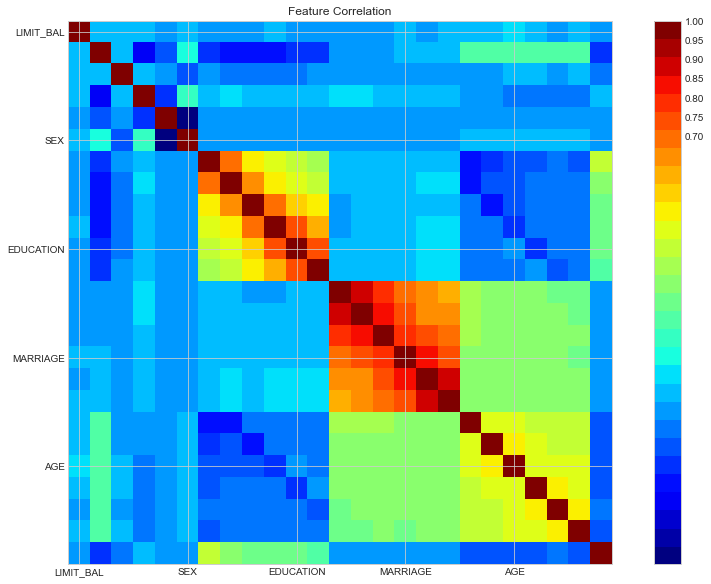

In [51]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(),interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_pay']
    ax1.set_yticklabels(labels)
    ax1.set_xticklabels(labels)
    fig.colorbar(cax, ticks=[.70,.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(data2)

<AxesSubplot:>

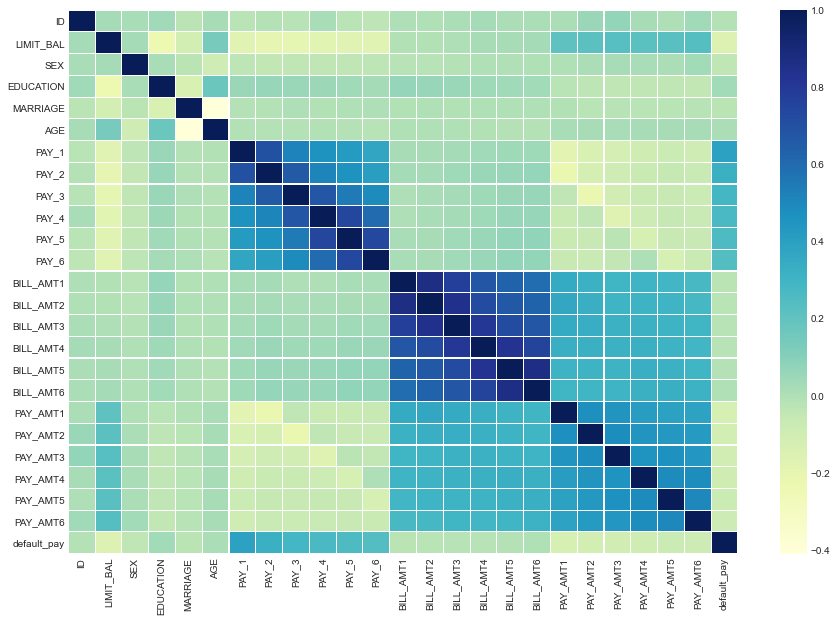

In [52]:
corrmat = data2.corr() 
f, ax = plt.subplots(figsize =(15, 10)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

In [53]:
#defining a function to give correlation between two columns
def correlation(Col1, Col2):
    res = data2.groupby([Col1, Col2]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [57]:
correlation('EDUCATION', 'default_pay')
#Higher the education lower is the probability of defaulting 

default_pay,0,1,perc
EDUCATION,,,
1,8549,2036,0.192348
2,10700,3330,0.237349
3,3680,1237,0.251576
4,435,33,0.070513


In [58]:
correlation('MARRIAGE', 'default_pay')
#married people and other are most likey gonna default

default_pay,0,1,perc
MARRIAGE,,,
1,10453,3206,0.234717
2,12623,3341,0.209283
3,288,89,0.236074


In [69]:
correlation('default_pay', 'SEX')

SEX,1,2,perc
default_pay,,,
0,9015,14349,0.614150
1,2873,3763,0.567058


I saw that men are most likely to default and also that married people are most likely to default. 
Thus why not combine them in a single variable given by the product of the two.
as we can see high correlation between the two categories hence we are going to combime 'SEX' and 'MARRIAGE' and make a new column

In [70]:
data2['gen_mar'] = 0
data2.loc[((data2.SEX == 1) & (data2.MARRIAGE == 1)) , 'gen_mar'] = 1 #married man
data2.loc[((data2.SEX == 1) & (data2.MARRIAGE == 2)) , 'gen_mar'] = 2 #single man
data2.loc[((data2.SEX == 1) & (data2.MARRIAGE == 3)) , 'gen_mar'] = 3 #divorced man
data2.loc[((data2.SEX == 2) & (data2.MARRIAGE == 1)) , 'gen_mar'] = 4 #married woman
data2.loc[((data2.SEX == 2) & (data2.MARRIAGE == 2)) , 'gen_mar'] = 5 #single woman
data2.loc[((data2.SEX == 2) & (data2.MARRIAGE == 3)) , 'gen_mar'] = 6 #divorced woman
correlation('gen_mar', 'default_pay')

default_pay,0,1,perc
gen_mar,,,
1,3844,1346,0.259345
2,5068,1485,0.226614
3,103,42,0.289655
4,6609,1860,0.219625
5,7555,1856,0.197216
6,185,47,0.202586


###  Deleting columns 'SEX' and 'MARRIAGE'


In [71]:
del data2['SEX']
del data2['MARRIAGE']

### Making bin for various age groups 

In [72]:
data2['Age_bin'] = pd.cut(data2.AGE, bins = 6, labels=[1,2,3,4,5,6])

In [73]:
data2.gen_mar.value_counts()

5    9411
4    8469
2    6553
1    5190
6     232
3     145
Name: gen_mar, dtype: int64

In [74]:
data2.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_pay',
       'gen_mar', 'Age_bin'],
      dtype='object')

In [75]:
data2.shape

(30000, 25)

In [76]:
cols = list(data2.columns)
cols = cols[:-3] + [cols[-2]] + [cols[-1]] +[cols[-3]]
data2 = data2[cols]

In [77]:
del data2['AGE']

In [78]:
data2.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'gen_mar', 'Age_bin',
       'default_pay'],
      dtype='object')

In [79]:
data2.shape

(30000, 24)

### Load the final dataset 

In [81]:
# # save data (without replacing -ve values + replacing outliers + feature selection) as pikel file 
# joblib.dump(data2, 'cleanedcreditcard_1.pkl')

['cleanedcreditcard_1.pkl']

In [3]:
# # Load the data(without replacing -ve values + replacing outliers + feature selection) clean data from the file 
# data2 = joblib.load('cleanedcreditcard_1.pkl')

In [65]:
# # save data (replacing -ve values + replacing outliers + feature selection) as pikel file 
# joblib.dump(data2, 'cleanedcreditcard_2.pkl')

['cleanedcreditcard_2.pkl']

In [3]:
# Load the data(without replacing -ve values + replacing outliers + feature selection) clean data from the file 
data2 = joblib.load('cleanedcreditcard_2.pkl')

In [80]:
y = data2.iloc[:, -1].values

In [81]:
X = data2.iloc[:, 0:-1].values

In [83]:
df_train = data2.iloc[:22500, :]
df_test = data2.iloc[22500:, :]

In [84]:
from sklearn.utils import resample

In [85]:
df_majority = df_train[df_train.default_pay==0]
df_minority = df_train[df_train.default_pay==1]

In [94]:
print("Majority default payee: " + str(df_majority.default_pay.count()))
print("Minority default payee: " + str(df_minority.default_pay.count()))
print("TOtal default payee in training set: " +str(df_train.default_pay.value_counts()))

Majority default payee: 17412
Minority default payee: 5088
TOtal default payee in training set: 0    17412
1     5088
Name: default_pay, dtype: int64


In [95]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=17412,    # to match majority class
                                 random_state=5) # reproducible results

In [96]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [97]:
# Display new class counts
df_upsampled.default_pay.value_counts()

1    17412
0    17412
Name: default_pay, dtype: int64

In [98]:
df_upsampled.shape

(34824, 24)

In [99]:
df_upsampled.columns[-1]

'default_pay'

In [100]:
X = df_upsampled.iloc[:, 0:-1].values
y = df_upsampled.iloc[:,-1].values

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

### Applying various ML models to check the accuracy 

### 1. Naive Bayes 

In [7]:
y_train = y_train.astype('int')

In [9]:
# Fitting Naive Bayes to the Training set(95%, 92% us)
from sklearn.naive_bayes import GaussianNB
classifier_naive = GaussianNB()
classifier_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [10]:
y_pred_test = classifier_naive.predict(X_test)

In [11]:
y_pred_train = classifier_naive.predict(X_train)

In [12]:
y_test = y_test.astype('int')

In [25]:
# New Model Evaluation metrics for test data(data = cleanedcreditcard_2)(upsampled)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.5722490236618424
Precision Score : 0.5587301587301587
Recall Score : 0.6873420629450954
F1 Score : 0.6163988463123198


In [13]:
# New Model Evaluation metrics for test data(data = cleanedcreditcard_2)( without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.6761333333333334
Precision Score : 0.31805293005671076
Recall Score : 0.405666063893912
F1 Score : 0.3565562913907284


In [26]:
# New Model Evaluation metrics for train data (-ve replaced)(data = cleanedcreditcard_2)(upsampled)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.5861474844934528
Precision Score : 0.5705948795180723
Recall Score : 0.6963014013324145
F1 Score : 0.6272115882048629


In [14]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_2)(without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.6901777777777778
Precision Score : 0.33976213436194147
Recall Score : 0.4247538677918425
F1 Score : 0.3775337083668185


In [23]:
# New Model Evaluation metrics for test data(data = cleanedcreditcard_1)(upsampled)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.5736273834137376
Precision Score : 0.5597836224584966
Recall Score : 0.6894096025729382
F1 Score : 0.6178711138562899


In [24]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)(upsampled)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.5861474844934528
Precision Score : 0.5704622322435174
Recall Score : 0.6974500344589938
F1 Score : 0.6275968992248062


In [27]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)(upsampled)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 2992
False Positive: 2363
True Negative: 1990
False Negative: 1361
Precision: 0.56
Recall: 0.69
Problematic ratio: 0.31


In [76]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)(upsampled)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 676
False Positive: 1441
True Negative: 4400
False Negative: 983
Precision: 0.32
Recall: 0.41
Problematic ratio: 0.59


In [25]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 3001
False Positive: 2360
True Negative: 1993
False Negative: 1352
Precision: 0.56
Recall: 0.69
Problematic ratio: 0.31


### 2. Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
y_pred_test = regressor.predict(X_test)

In [17]:
y_pred_test = y_pred_test.astype('int')

In [18]:
y_pred_train = regressor.predict(X_train)

In [19]:
y_pred_train = y_pred_train.astype('int')

In [33]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 159
False Positive: 20
True Negative: 4331
False Negative: 4186
Precision: 0.89
Recall: 0.04
Problematic ratio: 0.96


In [34]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2) (with sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5157362738341373
Precision Score : 0.5157362738341373
Recall Score : 0.5157362738341373
F1 Score : 0.5157362738341373


In [21]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.7809333333333334
Precision Score : 0.7809333333333334
Recall Score : 0.7809333333333334
F1 Score : 0.7809333333333334


In [35]:
# New Model Evaluation metrics for train data (-ve replace)(data = cleanedcreditcard_2) (with sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5176889501493223
Precision Score : 0.5176889501493223
Recall Score : 0.5176889501493223
F1 Score : 0.5176889501493223


In [22]:
# New Model Evaluation metrics for train data (-ve replace)(data = cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.7810222222222222
Precision Score : 0.7810222222222222
Recall Score : 0.7810222222222222
F1 Score : 0.7810222222222221


In [128]:
# New Model Evaluation metrics for test data (without -ve replace)(data = cleanedcreditcard_1)
TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
pred = len(y_pred_test)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 156
False Positive: 20
True Negative: 4331
False Negative: 4189
Precision: 0.89
Recall: 0.04
Problematic ratio: 0.96


In [131]:
# New Model Evaluation metrics for test data (without -ve replace)(data = cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5153916838961635
Precision Score : 0.5153916838961635
Recall Score : 0.5153916838961635
F1 Score : 0.5153916838961635


In [132]:
# New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5173826479822344
Precision Score : 0.5173826479822344
Recall Score : 0.5173826479822344
F1 Score : 0.5173826479822344


### 3. Logistic Regression 

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
#Grid Search (cv)
from sklearn.model_selection import GridSearchCV
clf_grid = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc_cv = GridSearchCV(clf_grid, param_grid = grid_values, cv = 10)
grid_clf_acc_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']})

In [25]:
y_test_pred = grid_clf_acc_cv.predict(X_test)

In [26]:
y_pred_train = grid_clf_acc_cv.predict(X_train)

In [40]:
# # New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5157362738341373
Precision Score : 0.5157362738341373
Recall Score : 0.5157362738341373
F1 Score : 0.5157362738341373


In [27]:
# New Model Evaluation metrics for test data (-ve replaced)(data = cleanedcreditcard_2)(without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.7809333333333334
Precision Score : 0.7809333333333334
Recall Score : 0.7809333333333334
F1 Score : 0.7809333333333334


In [41]:
# # New Model Evaluation metrics for train data (-ve replaced)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
# print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
# print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
# print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5885213262883835
Precision Score : 0.5885213262883835
Recall Score : 0.5885213262883835
F1 Score : 0.5885213262883835


In [28]:
# New Model Evaluation metrics for train data (-ve replaced)(data = cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.7789333333333334
Precision Score : 0.7789333333333334
Recall Score : 0.7789333333333334
F1 Score : 0.7789333333333334


In [37]:
# New Model Evaluation metrics for test data (without -ve replaced)(data = cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_test, average='micro')))
print('Recall Score : ' + str(recall_score(y_test,y_pred_test, average='micro')))
print('F1 Score : ' + str(f1_score(y_test,y_pred_test, average='micro')))

Accuracy Score : 0.5153916838961635
Precision Score : 0.5153916838961635
Recall Score : 0.5153916838961635
F1 Score : 0.5153916838961635


In [38]:
# New Model Evaluation metrics for train data (data = cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train, average='micro')))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train, average='micro')))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train, average='micro')))

Accuracy Score : 0.5885596140592695
Precision Score : 0.5885596140592695
Recall Score : 0.5885596140592695
F1 Score : 0.5885596140592695


In [89]:
# # New Model Evaluation metrics for test data (without -ve replace)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_test)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_test)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_test)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_test)))

Accuracy Score : 0.7809333333333334
Precision Score : 0.7222222222222222
Recall Score : 0.01567209162145871
F1 Score : 0.030678466076696168


In [90]:
# # New Model Evaluation metrics for train data (without -ve replace)(data = cleanedcreditcard_2)
# print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
# print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
# print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
# print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.7786666666666666
Precision Score : 0.2857142857142857
Recall Score : 0.0004018485031143259
F1 Score : 0.0008025682182985555


In [92]:
# TP = np.sum(np.logical_and(y_pred_test == 1, y_test == 1))
# TN = np.sum(np.logical_and(y_pred_test == 0, y_test == 0))
# FP = np.sum(np.logical_and(y_pred_test == 1, y_test == 0))
# FN = np.sum(np.logical_and(y_pred_test == 0, y_test == 1))
# pred = len(y_pred_test)

# print('True Positives: {}'.format(TP))
# print('False Positive: {}'.format(FP))
# print('True Negative: {}'.format(TN))
# print('False Negative: {}'.format(FN))
# print('Precision: {}'.format(round(TP/(TP+FP),2)))
# print('Recall: {}'.format(round(TP/(TP+FN),2)))
# print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

True Positives: 26
False Positive: 10
True Negative: 5831
False Negative: 1633
Precision: 0.72
Recall: 0.02
Problematic ratio: 0.98


### Deep learning 

In [34]:
import tensorflow as tf
import keras 
import time 
from keras.models import Sequential #(used to initialise the nural network)
from keras.layers import Dense #(used to create the layers in ANN)

In [35]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds#contains tokeniser  
from keras.layers import Dropout

In [36]:
# Initialising the ANN
classifier = Sequential()

In [37]:
y_train.shape

(22500,)

In [38]:
X_train.shape

(22500, 23)

In [39]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

In [40]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu', input_dim = 23))
    classifier.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [41]:
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [10],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [42]:
y_test = y_test.astype('int')

In [43]:
y_train = y_train.astype('int')

In [44]:
%time
grid_search = grid_search.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Epoch 1/10
20250/20250 [==============================] - 2s 75us/step - loss: 0.5416 - accuracy: 0.7737
Epoch 2/10
20250/20250 [==============================] - 2s 75us/step - loss: 0.5124 - accuracy: 0.7802
Epoch 3/10
20250/20250 [==============================] - 3s 147us/step - loss: 0.5085 - accuracy: 0.7803
Epoch 4/10
20250/20250 [==============================] - 3s 147us/step - loss: 0.5078 - accuracy: 0.7803
Epoch 5/10
20250/20250 [==============================] - 2s 118us/step - loss: 0.5078 - accuracy: 0.7803
Epoch 6/10
20250/20250 [==============================] - 3s 134us/step - loss: 0.5065 - accuracy: 0.7805
Epoch 7/10
20250/20250 [==============================] - 5s 253us/step - loss: 0.5059 - accuracy: 0.78051s
Epoch 8/10
20250/20250 [==============================] - 4s 176us/step - loss: 0.5071 - accuracy: 0.7798
Epoch 9/10
20250/20250 [==============================] - 3s 160us/step - loss: 0.5070 -

In [45]:
y_pred = grid_search.predict(X_test)

In [46]:
y_pred_train = grid_search.predict(X_train)

In [47]:
y_pred_train = (y_pred_train > 0.5)

In [48]:
y_pred_train = y_pred_train.astype('int')

In [49]:
y_pred = (y_pred > 0.5)

In [50]:
y_pred = y_pred.astype('int')

In [60]:
# New Model Evaluation metrics Train (data - cleanedcreditcard_2)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.5048242591316333
Precision Score : 0.5024333719582851
Recall Score : 0.9960946473696302
F1 Score : 0.6679503966725719


In [51]:
# New Model Evaluation metrics Train (data - cleanedcreditcard_2)(without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.7789333333333334
Precision Score : 0.6363636363636364
Recall Score : 0.0014064697609001407
F1 Score : 0.002806736166800321


In [118]:
# New Model Evaluation metrics Train (data - cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))

Accuracy Score : 0.6096944635883299
Precision Score : 0.5916682664618929
Recall Score : 0.708017459223524
F1 Score : 0.6446350135954821


In [61]:
# New Model Evaluation metrics Test (data - cleanedcreditcard_2)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.5056283023202389
Precision Score : 0.5028392629505157
Recall Score : 0.9967838272455778
F1 Score : 0.6684640271144663


In [52]:
# New Model Evaluation metrics Test (data - cleanedcreditcard_2) (without sampling)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.7794666666666666
Precision Score : 1.0
Recall Score : 0.0030138637733574444
F1 Score : 0.006009615384615385


In [112]:
# New Model Evaluation metrics Test (data - cleanedcreditcard_1)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.6006202618883528
Precision Score : 0.5847523219814241
Recall Score : 0.6942338617045716
F1 Score : 0.6348072681441025


In [113]:
#model evaluation for test (data - cleanedcreditcard_1)
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.62      0.51      0.56      4353
    positive       0.58      0.69      0.63      4353

    accuracy                           0.60      8706
   macro avg       0.60      0.60      0.60      8706
weighted avg       0.60      0.60      0.60      8706



In [64]:
#model evaluation for test (data - cleanedcreditcard_2)
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.82      0.01      0.03      4353
    positive       0.50      1.00      0.67      4353

    accuracy                           0.51      8706
   macro avg       0.66      0.51      0.35      8706
weighted avg       0.66      0.51      0.35      8706

